In [1]:
import polars as pl

print("Loading CSVs and printing schemas…")
biz_raw   = pl.read_csv("processed/businesses.csv")
rev_raw   = pl.read_csv("processed/reviews.csv")
users_raw = pl.read_csv("processed/users.csv")
fr_raw    = pl.read_csv("processed/friendships.csv")

print("businesses.csv columns:", biz_raw.columns)
print("reviews.csv    columns:", rev_raw.columns)
print("users.csv      columns:", users_raw.columns)
print("friendships.csv columns:", fr_raw.columns)


Loading CSVs and printing schemas…
businesses.csv columns: ['business_id', 'name', 'city', 'state', 'latitude', 'longitude', 'stars', 'review_count', 'categories']
reviews.csv    columns: ['review_id', 'user_id', 'business_id', 'stars', 'date', 'useful', 'funny', 'cool', 'text']
users.csv      columns: ['user_id', 'name', 'yelping_since', 'review_count_total', 'useful', 'funny', 'cool', 'elite_years']
friendships.csv columns: ['user_id', 'friend_id']


In [10]:
# Inspect raw strings
print("Raw review date samples:")
print(rev_raw.select("date").head(5))

print("\nRaw yelping_since samples:")
print(users_raw.select("yelping_since").head(5))


Raw review date samples:
shape: (5, 1)
┌─────────────────────┐
│ date                │
│ ---                 │
│ str                 │
╞═════════════════════╡
│ 2018-07-07 22:09:11 │
│ 2012-01-03 15:28:18 │
│ 2014-02-05 20:30:30 │
│ 2015-01-04 00:01:03 │
│ 2017-01-14 20:54:15 │
└─────────────────────┘

Raw yelping_since samples:
shape: (5, 1)
┌─────────────────────┐
│ yelping_since       │
│ ---                 │
│ str                 │
╞═════════════════════╡
│ 2007-01-25 16:47:26 │
│ 2009-01-25 04:35:42 │
│ 2008-07-25 10:41:00 │
│ 2005-11-29 04:38:33 │
│ 2007-01-05 19:40:59 │
└─────────────────────┘


In [13]:
import polars as pl
from datetime import datetime

# Step 2a: Parse review dates (overwrite `date` column)
rev = rev_raw.with_columns([
    pl.col("date")
      .str.strptime(pl.Date, "%Y-%m-%d %H:%M:%S", strict=False)
      .alias("date")
])

# Verify parsing
date_stats = rev.select([
    pl.col("date").min().alias("earliest"),
    pl.col("date").max().alias("latest")
])
print("Parsed review date range:\n", date_stats)

# Step 2b: Parse users’ yelping_since (overwrite that column)
users = users_raw.with_columns([
    pl.col("yelping_since")
      .str.strptime(pl.Date, "%Y-%m-%d %H:%M:%S", strict=False)
      .alias("yelping_since")
])

# Show a few samples to confirm
print("\nSample parsed yelping_since dates:")
print(users.select("yelping_since").head(5))


Parsed review date range:
 shape: (1, 2)
┌────────────┬────────────┐
│ earliest   ┆ latest     │
│ ---        ┆ ---        │
│ date       ┆ date       │
╞════════════╪════════════╡
│ 2005-02-16 ┆ 2022-01-19 │
└────────────┴────────────┘

Sample parsed yelping_since dates:
shape: (5, 1)
┌───────────────┐
│ yelping_since │
│ ---           │
│ date          │
╞═══════════════╡
│ 2007-01-25    │
│ 2009-01-25    │
│ 2008-07-25    │
│ 2005-11-29    │
│ 2007-01-05    │
└───────────────┘


In [14]:
from datetime import datetime

# Step 3a: Define TODAY based on latest review date
latest = rev.select(pl.col("date").max()).item()    # 2022-01-19
TODAY  = datetime.combine(latest, datetime.min.time())
print(f"TODAY = {TODAY.date()}")

# Compute 12-months-ago
one_year_ago = TODAY.replace(year=TODAY.year - 1)
print(f"Filtering reviews from {one_year_ago.date()} to {TODAY.date()}")

# Step 3b: Apply seasonality filter
rev_last12 = rev.filter(
    (pl.col("date") >= one_year_ago.date()) &
    (pl.col("date") <= TODAY.date())
)
print("Reviews in last 12 months:", rev_last12.shape)


TODAY = 2022-01-19
Filtering reviews from 2021-01-19 to 2022-01-19
Reviews in last 12 months: (623243, 9)


In [15]:
# Step 4: Business churn filter
# Start from your raw businesses DataFrame
biz = biz_raw

# 4a) Compute percentiles
percentiles = biz.select([
    pl.col("review_count").quantile(q).alias(f"{int(q*100)}th")
    for q in (0.25, 0.5, 0.75, 0.9)
])
print("Review-count percentiles:\n", percentiles)

# 4b) Choose threshold
MIN_BIZ_REVIEWS = 30
median_reviews    = percentiles["50th"][0]
if median_reviews < MIN_BIZ_REVIEWS / 2:
    MIN_BIZ_REVIEWS = max(5, int(median_reviews))
print(f"Using MIN_BIZ_REVIEWS = {MIN_BIZ_REVIEWS}")

# 4c) Apply filter
biz_alive = biz.filter(pl.col("review_count") >= MIN_BIZ_REVIEWS)
print("Businesses surviving churn filter:", biz_alive.shape)


Review-count percentiles:
 shape: (1, 4)
┌──────┬──────┬──────┬──────┐
│ 25th ┆ 50th ┆ 75th ┆ 90th │
│ ---  ┆ ---  ┆ ---  ┆ ---  │
│ f64  ┆ f64  ┆ f64  ┆ f64  │
╞══════╪══════╪══════╪══════╡
│ 8.0  ┆ 15.0 ┆ 37.0 ┆ 97.0 │
└──────┴──────┴──────┴──────┘
Using MIN_BIZ_REVIEWS = 30
Businesses surviving churn filter: (45338, 9)


In [17]:
# Step 5a: Inspect available states
state_counts = biz_alive \
    .group_by("state") \
    .agg(pl.count().alias("n")) \
    .sort("n", descending=True) \
    .head(10)
print("Top states in data:\n", state_counts)


Top states in data:
 shape: (10, 2)
┌───────┬───────┐
│ state ┆ n     │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ PA    ┆ 10635 │
│ FL    ┆ 7651  │
│ TN    ┆ 3839  │
│ LA    ┆ 3635  │
│ IN    ┆ 3415  │
│ MO    ┆ 3362  │
│ AZ    ┆ 2992  │
│ NV    ┆ 2750  │
│ NJ    ┆ 2057  │
│ CA    ┆ 1969  │
└───────┴───────┘


C:\Users\NITRO\AppData\Local\Temp\ipykernel_15100\4024716159.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("n")) \


In [ ]:
import polars as pl

# Starting from biz_alive (output of your churn filter)
# Select all businesses where state == "LggA"
biz_vegas = biz_alive.filter(pl.col("state") == "LA")

print("Businesses in state LA:", biz_vegas.shape)
# biz_vegas now holds all 3,635 LA businesses for your downstream processing


Businesses in state LA: (3635, 9)


In [21]:
import polars as pl

# 6a) Grab just the IDs of your LA businesses
la_ids = biz_vegas.select("business_id")

# 6b) Inner-join to filter reviews to LA
rev_la = rev_last12.join(la_ids, on="business_id", how="inner")

print("Shape of reviews for LA businesses (rev_la):", rev_la.shape)

# 6c) Fallback if join wipes out all reviews
if rev_la.height == 0 and rev_last12.height > 0:
    print("⚠️ Join resulted in 0 reviews—keeping all last-12-month reviews instead")
    rev_la = rev_last12.clone()
    print("New rev_la shape:", rev_la.shape)


Shape of reviews for LA businesses (rev_la): (46362, 9)


In [22]:
import polars as pl

# Work from your rev_la (LA reviews)
# 7a) Count reviews per user
user_counts = rev_la.group_by("user_id") \
                    .agg(pl.len().alias("n_reviews"))

# 7b) Test thresholds
thresholds = [1, 2, 5, 10, 15]
print("Threshold → # of users")
for T in thresholds:
    n = user_counts.filter(pl.col("n_reviews") >= T).height
    print(f"  ≥{T:2d} → {n}")

# 7c) Pick ACTIVE_T: first T giving >=100 users, else 1
ACTIVE_T = next((t for t in thresholds 
                 if user_counts.filter(pl.col("n_reviews") >= t).height >= 100),
                1)
print(f"\nSelected ACTIVE_T = {ACTIVE_T}")

# 7d) Filter to active users
active_users = user_counts.filter(pl.col("n_reviews") >= ACTIVE_T) \
                          .select("user_id")
print("Active users shape:", active_users.shape)


Threshold → # of users
  ≥ 1 → 23446
  ≥ 2 → 7300
  ≥ 5 → 1676
  ≥10 → 464
  ≥15 → 239

Selected ACTIVE_T = 1
Active users shape: (23446, 1)


In [ ]:
# Use the previously parsed `users` table and `active_users`
users_active = users.join(active_users, on="user_id", how="inner")
print("users_active shape:", users_active.shape)


users_active shape: (23445, 8)


In [24]:
# Use the original `fr_raw` table
fr_active = fr_raw \
    .join(active_users, on="user_id", how="inner") \
    .join(active_users.rename({"user_id": "friend_id"}), on="friend_id", how="inner")

print("Mutual active friendships (fr_active) shape:", fr_active.shape)

# Fallback: if none survived
if fr_active.height == 0:
    print("⚠️ No mutual friendships found—falling back to one-sided join.")
    fr_active = fr_raw.join(active_users, on="user_id", how="inner")
    print("One-sided active friendships shape:", fr_active.shape)


Mutual active friendships (fr_active) shape: (445, 2)


In [25]:
# Step 9: Co-review weighting

# From rev_la (filtered reviews), select unique (business_id, user_id) pairs
co_reviews = (
    rev_la.select(["business_id", "user_id"])
          .unique()
          .group_by("business_id")
          .agg(pl.col("user_id").implode().alias("user_list"))
          .explode("user_list")
          .rename({"user_list": "user_id"})
)

# Self-join to get all user pairs who reviewed same businesses
pairs = (
    co_reviews
    .join(co_reviews.rename({"user_id": "friend_id"}), on="business_id")
    .filter(pl.col("user_id") < pl.col("friend_id"))  # avoid duplicate/reverse pairs
    .group_by(["user_id", "friend_id"])
    .agg(pl.len().alias("co_review_count"))
)

# Join co-review counts onto friendship graph
fr_active_weighted = (
    fr_active
    .join(pairs, on=["user_id", "friend_id"], how="left")
    .with_columns(pl.col("co_review_count").fill_null(0))
)

print("Weighted friendships (with co_review_count):", fr_active_weighted.shape)


Weighted friendships (with co_review_count): (445, 3)


In [26]:
import os

# Final tables to export
output_dir = "processed_filtered"
os.makedirs(output_dir, exist_ok=True)

# Save all four datasets
biz_vegas.write_csv(f"{output_dir}/vegas_businesses_filtered.csv")
rev_la.write_csv(f"{output_dir}/vegas_reviews_filtered.csv")
users_active.write_csv(f"{output_dir}/vegas_users_filtered.csv")
fr_active_weighted.write_csv(f"{output_dir}/vegas_friendships_weighted.csv")

print("\n✅ All done. Final datasets saved to:", output_dir)
print("Shapes:")
print("  Businesses :", biz_vegas.shape)
print("  Reviews    :", rev_la.shape)
print("  Users      :", users_active.shape)
print("  Friendships:", fr_active_weighted.shape)



✅ All done. Final datasets saved to: processed_filtered
Shapes:
  Businesses : (3635, 9)
  Reviews    : (46362, 9)
  Users      : (23445, 8)
  Friendships: (445, 3)


In [27]:
import polars as pl

# Load the weighted friendships file
df_weighted = pl.read_csv("processed_filtered/vegas_friendships_weighted.csv")

# Select only the user_id and friend_id columns
df_simple = df_weighted.select(["user_id", "friend_id"])

# Save the simplified version
df_simple.write_csv("processed_filtered/vegas_friendships.csv")

print("✅ Saved simplified friendship edges to 'processed_filtered/vegas_friendships.csv'")


✅ Saved simplified friendship edges to 'processed_filtered/vegas_friendships.csv'


Neo4j connection successful.
Fetching core properties...
Fetching PageRank scores...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 61} for query: "// Drop the graph projection if it exists before creating it\nCALL gds.graph.drop('vegas_social_projection', false)"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 5, column: 22, offset: 152} for query: "\n// Run PageRank on the projected graph and stream results\nCALL gds.pageRank.stream('vegas_social_projection')\nYIELD nodeId, score\nM

Fetching Betweenness Centrality scores...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 4, column: 22, offset: 109} for query: "\nCALL gds.betweenness.stream('vegas_social_projection_betweenness')\nYIELD nodeId, score\nMATCH (u:User) WHERE id(u) = nodeId\nRETURN u.user_id AS user_id, score AS betweenness_centrality"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 1, offset: 61} for query: "// Drop the graph projection if it exists before creating it\nC

Fetching Eigenvector Centrality scores...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 4, column: 22, offset: 109} for query: "\nCALL gds.eigenvector.stream('vegas_social_projection_eigenvector')\nYIELD nodeId, score\nMATCH (u:User) WHERE id(u) = nodeId\nRETURN u.user_id AS user_id, score AS eigenvector_centrality"


Fetching elite connections and engagement scores...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: 'MATCH (u:User)\nOPTIONAL MATCH (u)-[:FRIENDS_WITH]->(elite_friend:User)\nWHERE elite_friend.elite_years IS NOT NULL AND size(elite_friend.elite_years) > 0\nOPTIONAL MATCH (u)-[:WROTE]->(r:Review)\nRETURN\n    u.user_id AS user_id,\n    count(DISTINCT elite_friend) AS num_elite_friends,\n    sum(r.useful + r.funny + r.cool) AS total_review_engagement_votes'



Merged DataFrame head:
                  user_id      name yelping_since  review_count_total  useful  \
0  X7SwvRrnsZ8I3bEPGELpnQ  Jennifer    2008-01-24                 666    1329   
1  0G-QF457q_0Z_jKqh6xWiA       Joi    2008-03-12                2009   27137   
2  WeiirhJyaAY9kQ1cS5ZhwA    Gerrit    2009-07-16                 108      91   
3  8TYNR25ifvwrwYcyKNx1BQ       Amy    2009-04-29                 408    1078   
4  XcwBT1a_5ZjdaPZTZOhN-Q      Tung    2011-04-03                 528     571   

   funny   cool  is_elite  pagerank_score  betweenness_centrality  \
0    590    470      True        0.150000                     0.0   
1  14049  20385      True        0.895875                     0.0   
2     26     22     False        0.150000                     0.0   
3    244    338      True        0.150000                     0.0   
4    141    259      True        0.150000                     0.0   

   eigenvector_centrality  num_elite_friends  total_review_engagement_vote

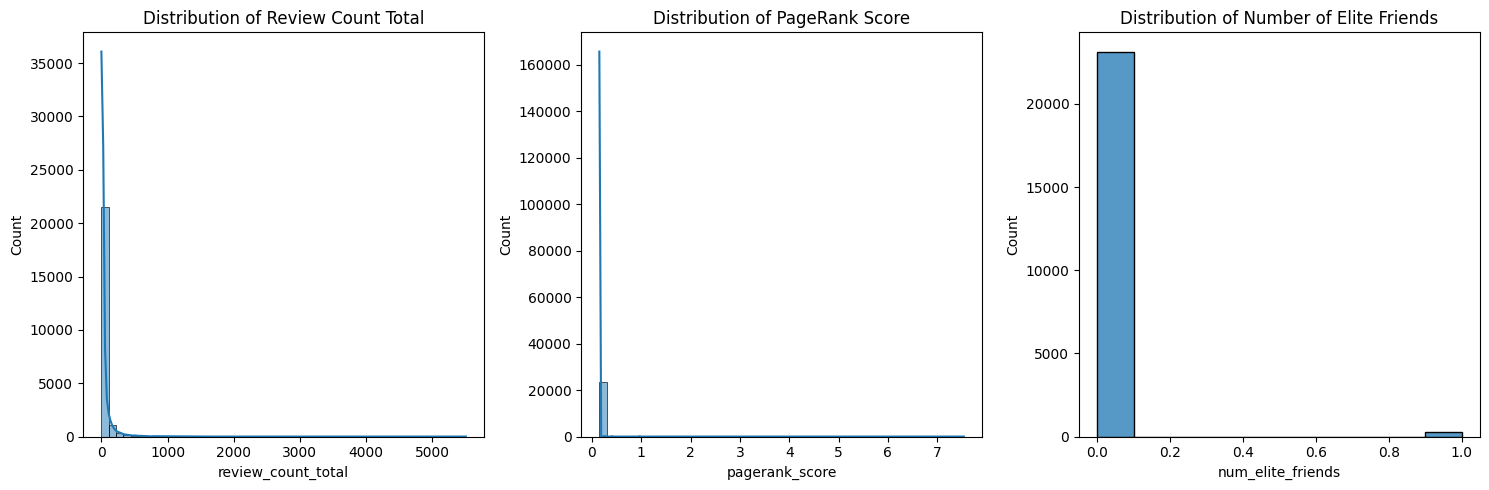


Correlation Matrix:


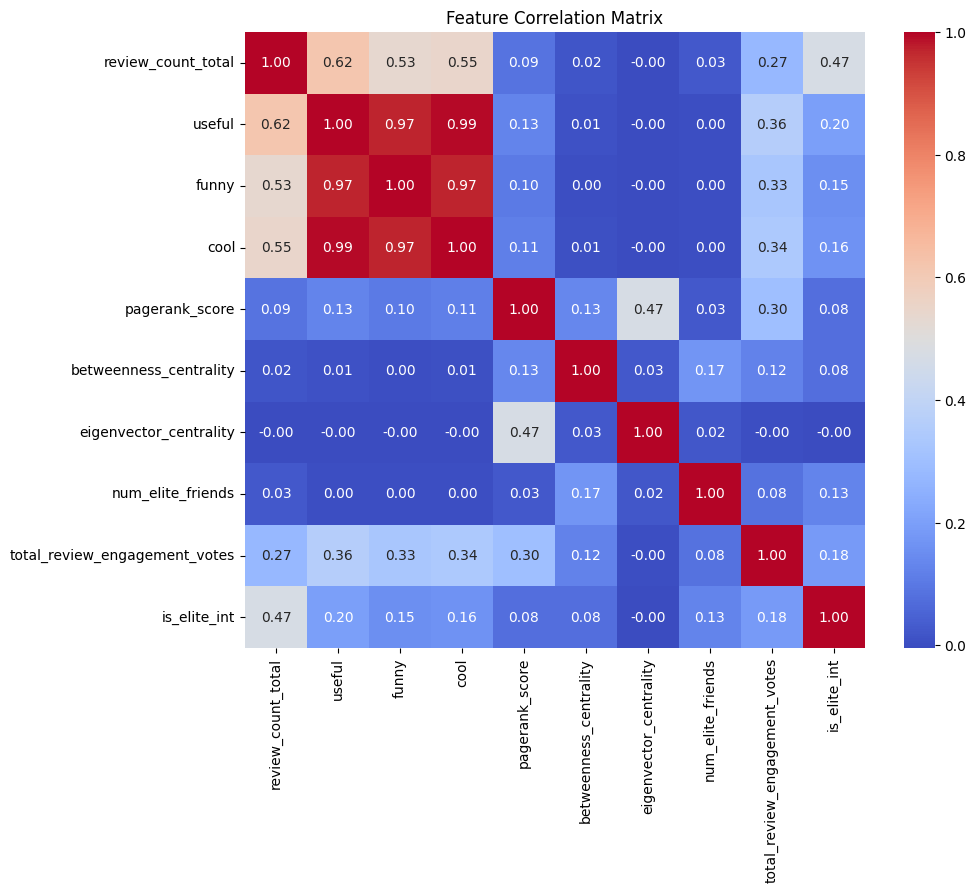


Training data shape: (18756, 9)
Testing data shape: (4689, 9)

Training RandomForestClassifier...
Model training complete.

Evaluating model on test set:
              precision    recall  f1-score   support

       False       0.97      0.98      0.98      4166
        True       0.84      0.77      0.80       523

    accuracy                           0.96      4689
   macro avg       0.90      0.87      0.89      4689
weighted avg       0.96      0.96      0.96      4689

Accuracy: 0.9573469822989976

Feature Importances:
cool                             0.338217
review_count_total               0.276280
useful                           0.234076
funny                            0.098362
total_review_engagement_votes    0.046647
num_elite_friends                0.003366
eigenvector_centrality           0.001448
pagerank_score                   0.001293
betweenness_centrality           0.000311
dtype: float64


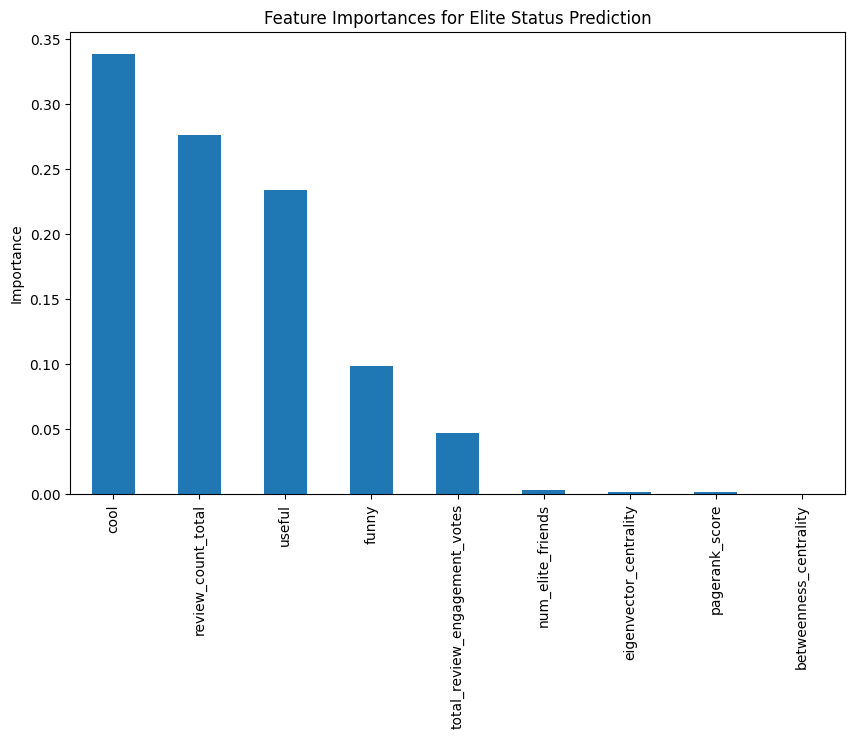


Predicting elite status probability for currently non-elite users:

Top 10 most likely future elite users:
                      user_id     name  elite_probability  review_count_total  \
8757   8DnBMIfDWnR5kI9nLwl4Hg      Kim               1.00                 178   
1727   nNmu18mfl-NJAKaB085oxQ   Kellie               0.97                 178   
1245   V7ajqNkC8jUpoJrj4YsRNw     Lisa               0.96                 437   
356    EZGqZeSsWuxRoQ7Np_FYmA     Fred               0.96                 282   
1811   GsGafjiGGzvbzw3SC8gW-g      Hal               0.95                 117   
1799   L8dq_1M3PvXeN4502PI2Ig    Sally               0.93                 221   
931    wUKf9wve4y8kTym4usWFSg     Nola               0.93                1072   
6400   uB61MiqCg_VV9wzDtCK7Gg  Araceli               0.93                 449   
8739   iH3YCM1zDyAeGExOVjRTxQ   Walter               0.91                 141   
12438  N3FmJPsGh7hmqAa6DgbaiA   Skylar               0.90                 129   



In [2]:
from neo4j import GraphDatabase
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np # Import numpy for handling potential NaN values
import matplotlib.pyplot as plt # For basic data exploration plots
import seaborn as sns # For enhanced data exploration plots

# Neo4j connection details (Update with your credentials)
uri = "bolt://localhost:7687"
username = "neo4j"
password = "neo4jneo5j" # <--- IMPORTANT: Replace with your actual Neo4j password

# Connect to Neo4j
try:
    driver = GraphDatabase.driver(uri, auth=(username, password))
    driver.verify_connectivity()
    print("Neo4j connection successful.")
except Exception as e:
    print(f"Failed to connect to Neo4j: {e}")
    exit()

def fetch_data(driver, query):
    """
    Fetches data from Neo4j using a Cypher query.
    Handles multi-statement GDS queries by running statements sequentially.
    """
    def execute_query_and_collect(tx):
        # Split query into statements if it contains multiple GDS calls
        # This is a simple split; more complex queries might need a robust parser
        statements = query.strip().split(';')
        results = None # Store the result from the last statement (the stream)

        for statement in statements:
            # Skip empty statements caused by splitting
            if not statement.strip():
                continue
            # Execute each statement within the transaction
            # We don't need to collect results from intermediate statements (like DROP or PROJECT)
            # Check if the statement is a GDS drop or project call
            if statement.strip().lower().startswith('call gds.graph.drop') or statement.strip().lower().startswith('call gds.graph.project'):
                 tx.run(statement)
                 results = None # Ensure results is None for non-streaming calls
            else:
                # This should be the streaming call, capture its results
                results = tx.run(statement)


        # Consume the result iterator and collect all data as a list of dictionaries
        # Ensure results is not None (handles case where query might be empty or only project)
        data = [r.data() for r in results] if results else []
        return data

    with driver.session() as session:
        # Execute the read transaction using the helper function
        # The helper function collects all data before the transaction is closed
        data = session.execute_read(execute_query_and_collect)
        # Create the DataFrame from the collected data after the transaction
        return pd.DataFrame(data)


# --- Cypher Queries (These match the ones in the Canvas) ---

# Query 1: Core user properties and target variable
query_core_properties = """
MATCH (u:User)
RETURN
    u.user_id AS user_id,
    u.name AS name,
    u.yelping_since AS yelping_since,
    u.review_count_total AS review_count_total,
    u.useful AS useful,
    u.funny AS funny,
    u.cool AS cool,
    CASE
        WHEN u.elite_years IS NOT NULL AND size(u.elite_years) > 0 THEN true
        ELSE false
    END AS is_elite;
"""

# Query 2: PageRank (Streaming from GDS)
query_pagerank = """
// Drop the graph projection if it exists before creating it
CALL gds.graph.drop('vegas_social_projection', false);
// Project the graph for PageRank calculation (focusing on User and FRIENDS_WITH)
CALL gds.graph.project(
    'vegas_social_projection',
    'User',
    'FRIENDS_WITH'
);
// Run PageRank on the projected graph and stream results
CALL gds.pageRank.stream('vegas_social_projection')
YIELD nodeId, score
MATCH (u:User) WHERE id(u) = nodeId
RETURN u.user_id AS user_id, score AS pagerank_score;
"""

# Query 3: Betweenness Centrality (Streaming from GDS)
query_betweenness = """
// Drop the graph projection if it exists before creating it
CALL gds.graph.drop('vegas_social_projection_betweenness', false);
// Project the graph for Betweenness Centrality
CALL gds.graph.project(
    'vegas_social_projection_betweenness',
    'User',
    'FRIENDS_WITH'
);
CALL gds.betweenness.stream('vegas_social_projection_betweenness')
YIELD nodeId, score
MATCH (u:User) WHERE id(u) = nodeId
RETURN u.user_id AS user_id, score AS betweenness_centrality;
"""

# Query 4: Eigenvector Centrality (Streaming from GDS)
query_eigenvector = """
// Drop the graph projection if it exists before creating it
CALL gds.graph.drop('vegas_social_projection_eigenvector', false);
// Project the graph for Eigenvector Centrality
CALL gds.graph.project(
    'vegas_social_projection_eigenvector',
    'User',
    'FRIENDS_WITH'
);
CALL gds.eigenvector.stream('vegas_social_projection_eigenvector')
YIELD nodeId, score
MATCH (u:User) WHERE id(u) = nodeId
RETURN u.user_id AS user_id, score AS eigenvector_centrality;
"""

# Query 5: Calculate Elite Connections and Engagement Score
query_connections_engagement = """
MATCH (u:User)
OPTIONAL MATCH (u)-[:FRIENDS_WITH]->(elite_friend:User)
WHERE elite_friend.elite_years IS NOT NULL AND size(elite_friend.elite_years) > 0
OPTIONAL MATCH (u)-[:WROTE]->(r:Review)
RETURN
    u.user_id AS user_id,
    count(DISTINCT elite_friend) AS num_elite_friends,
    sum(r.useful + r.funny + r.cool) AS total_review_engagement_votes;
"""

# --- Fetch Data ---
print("Fetching core properties...")
df_core = fetch_data(driver, query_core_properties)

print("Fetching PageRank scores...")
df_pagerank = fetch_data(driver, query_pagerank)

print("Fetching Betweenness Centrality scores...")
df_betweenness = fetch_data(driver, query_betweenness)

print("Fetching Eigenvector Centrality scores...")
df_eigenvector = fetch_data(driver, query_eigenvector)

print("Fetching elite connections and engagement scores...")
df_connections_engagement = fetch_data(driver, query_connections_engagement)


# --- Merge DataFrames ---
# Start with core properties
df_merged = df_core

# Merge centrality scores (assuming user_id is the join key)
# Use how='left' to keep all users from the core properties dataframe
df_merged = pd.merge(df_merged, df_pagerank, on='user_id', how='left')
df_merged = pd.merge(df_merged, df_betweenness, on='user_id', how='left')
df_merged = pd.merge(df_merged, df_eigenvector, on='user_id', how='left')
df_merged = pd.merge(df_merged, df_connections_engagement, on='user_id', how='left')

print("\nMerged DataFrame head:")
print(df_merged.head())
print(f"\nTotal users fetched: {len(df_merged)}")
print("\nMerged DataFrame Info:")
df_merged.info()

# --- Data Exploration (Basic) ---
print("\nBasic Data Description:")
print(df_merged.describe())

print("\nDistribution of 'is_elite':")
print(df_merged['is_elite'].value_counts())

# Visualize distribution of a few key features
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_merged['review_count_total'], bins=50, kde=True)
plt.title('Distribution of Review Count Total')

plt.subplot(1, 3, 2)
sns.histplot(df_merged['pagerank_score'], bins=50, kde=True)
plt.title('Distribution of PageRank Score')

plt.subplot(1, 3, 3)
sns.histplot(df_merged['num_elite_friends'], bins=10, kde=False)
plt.title('Distribution of Number of Elite Friends')

plt.tight_layout()
plt.show()

# Correlation matrix (excluding non-numeric and identifier columns)
numeric_cols = df_merged.select_dtypes(include=np.number).columns.tolist()
correlation_cols = [col for col in numeric_cols if col not in ['user_id']] # Exclude user_id from correlation
# Ensure is_elite is treated numerically for correlation if it exists
if 'is_elite' in df_merged.columns:
    if 'is_elite' in correlation_cols:
         correlation_cols.remove('is_elite')
    # Convert boolean to integer for correlation calculation
    df_merged['is_elite_int'] = df_merged['is_elite'].astype(int)
    correlation_cols.append('is_elite_int')


print("\nCorrelation Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(df_merged[correlation_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()


# --- Data Preprocessing for Modeling ---

# Handle potential NaN values resulting from OPTIONAL MATCH or missing GDS scores
# Fill NaN centrality scores with 0 (or a suitable value based on analysis)
# Fill NaN engagement votes with 0
# Note: We already did this before, but repeating for clarity before modeling
df_merged['pagerank_score'] = df_merged['pagerank_score'].fillna(0)
df_merged['betweenness_centrality'] = df_merged['betweenness_centrality'].fillna(0)
df_merged['eigenvector_centrality'] = df_merged['eigenvector_centrality'].fillna(0)
df_merged['num_elite_friends'] = df_merged['num_elite_friends'].fillna(0)
df_merged['total_review_engagement_votes'] = df_merged['total_review_engagement_votes'].fillna(0)

# Define features (X) and target (y)
features = [
    'review_count_total',
    'useful',
    'funny',
    'cool',
    'pagerank_score',
    'betweenness_centrality',
    'eigenvector_centrality',
    'num_elite_friends',
    'total_review_engagement_votes'
    # Add other relevant features here if extracted
]
X = df_merged[features]
y = df_merged['is_elite']

# Handle potential infinity values in centrality scores (can happen with some graphs)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median()) # Fill remaining NaNs with median or other strategy (using median of the whole dataset)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to maintain class distribution

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- Train Model ---
print("\nTraining RandomForestClassifier...")
# Using balanced class weight is important due to likely imbalance between elite/non-elite users
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
print("Model training complete.")

# --- Evaluate Model ---
print("\nEvaluating model on test set:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Display feature importances
print("\nFeature Importances:")
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print(feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances for Elite Status Prediction')
plt.ylabel('Importance')
plt.show()


# --- Predict on Currently Non-Elite Users ---
print("\nPredicting elite status probability for currently non-elite users:")

# Filter the original merged DataFrame to get only non-elite users
df_non_elite = df_merged[df_merged['is_elite'] == False].copy()

# Prepare the feature set for prediction
X_predict = df_non_elite[features]

# Handle potential infinity/NaN in prediction set using the same strategy as training data
X_predict = X_predict.replace([np.inf, -np.inf], np.nan)
X_predict = X_predict.fillna(X.median()) # Use median from the *training* data (X) for consistency

# Get prediction probabilities for the positive class (True/Elite)
predict_probabilities = model.predict_proba(X_predict)[:, 1]

# Add prediction probabilities to the non-elite DataFrame
df_non_elite['elite_probability'] = predict_probabilities

# Sort by probability to see the most likely future elite users
df_predict_sorted = df_non_elite.sort_values(by='elite_probability', ascending=False)

print("\nTop 10 most likely future elite users:")
print(df_predict_sorted[['user_id', 'name', 'elite_probability', 'review_count_total', 'num_elite_friends']].head(10))

# Close Neo4j connection
driver.close()
print("\nNeo4j connection closed.")
print("Elite status prediction script finished.")